In [51]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
from torchviz import make_dot

from math import ceil
import sys
from torch_harmonics.sht import *
from torch.utils.data import DataLoader
from torch_harmonics.examples.wave_dataset import WaveDataset, gen_random_gaussian_handle

cmap='twilight_shifted'

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialization of parameters:

In [53]:
nlat = 128
nlon = 2*nlat # More longitude ponints than latitude
lmax = ceil(nlon/4)
mmax = lmax # As much m values as l for the spherical harmonic functions.

In [54]:
# Parameters
R = 1.0
c = 1.0
Lmax = 64

t0 = 0 # initial time of the training range
dt = 0.1 #timestop
history = 4 #how many past steps to add (minimum 1)

tf = 5 # final time of the training range.
t_range= (t0, tf)
normalize=True,
nfuture=0 # How many future prediction steps to compute at once (Beta Feature)

# Create Wave Dataset object

In [55]:
dataset = WaveDataset(t0, dt, c, R, (nlat, nlon), 
                      history=history, t_range=t_range,
                      normalize=normalize, nfuture=nfuture)

In [56]:
#channels x latitude x longitude
print(f"input data shape {dataset[0][0].shape}") 
print(f"target data shape {dataset[0][1].shape}")

input data shape torch.Size([4, 128, 256])
target data shape torch.Size([1, 128, 256])


## Visualization of randomly generated parameters

In [57]:
t_vec = np.arange(t0, tf, dt) #t0, tf, dt
f_handle = gen_random_gaussian_handle()
g_handle = lambda x, y, z: 0 * x
s = 0; ch = 0 # Sample and c

inp0 = torch.tensor(f_handle(dataset._X, dataset._Y, dataset._Z).T)
#inp = dataset.time2grid(f_handle, g_handle, t_vec[:history]).unsqueeze(0)

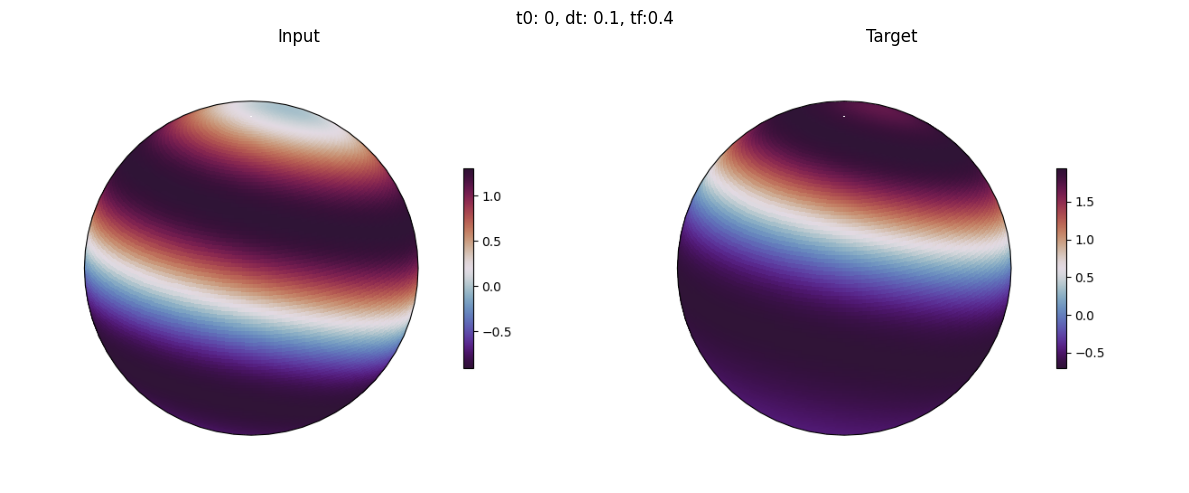

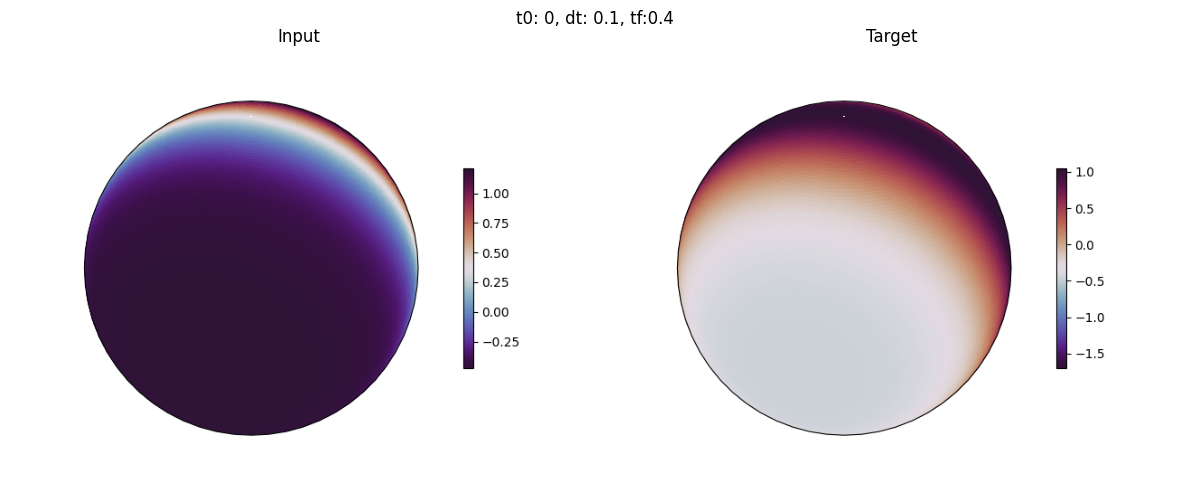

In [87]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, persistent_workers=False)

for _ in range(2):
    inp, tar = next(iter(dataloader))
    data_list = [inp[0,0, ...], tar[0,0, ...]]
    images = []
    
    for data in data_list:
        fig = plt.figure()

        # Plot the spherical grid
        dataset.plot_griddata(data, fig, projection='3d')

        # Add colorbar from last plotted collection
        ax = fig.gca()                # works even with 3D projection
        mappable = ax.collections[-1] # last plotted object (surface/mesh)
        fig.colorbar(mappable, ax=ax, shrink=0.6, pad=0.1)

        fig.canvas.draw()

        # Convert canvas → RGB
        w, h = fig.canvas.get_width_height()
        buf = np.asarray(fig.canvas.buffer_rgba())
        img = buf.reshape((h, w, 4))[:, :, :3]
        images.append(img)

        plt.close(fig)

    # Combine into side-by-side figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax, img, title in zip(axes, images, ["Input", "Target"]):
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(title)

    fig.suptitle(f"t0: {t0}, dt: {dt}, tf:{t0+dt*history}")
    plt.tight_layout()
    plt.show()


# Generate video for the whole time range

In [59]:
# f_handle = gen_random_gaussian_handle()
# g_handle = lambda x, y, z: 0 * x # zero velocity

# dataset.generate_video((f_handle, g_handle))

# Define Model Architecture and Start Training

In [60]:
from torch_harmonics.examples.models.sfno import SphericalFourierNeuralOperator as SFNO
from torch.utils.data import DataLoader
from torch.cuda import amp

In [61]:
#Dataloader generates the dataset to train.
# As of now, the dataloader gets a batch_size number of samples, where each sample is a different f_handle.
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, persistent_workers=False)

In [62]:
# Deffining the cost function. Just the l2 norm within S2.
def l2loss_sphere(dataset, prd, tar, relative=False, squared=True):
    loss = dataset.integrate_grid((prd - tar)**2, dimensionless=True).sum(dim=-1)
    if relative:
        loss = loss / dataset.integrate_grid(tar**2, dimensionless=True).sum(dim=-1)
    if not squared:
        loss = torch.sqrt(loss)
    loss = loss.mean()
    return loss

In [63]:
model = SFNO(img_size=(nlat, nlon), grid="legendre-gauss", num_layers=4, in_chans=history, out_chans=1,
             scale_factor=4, embed_dim=16, use_mlp=False, normalization_layer="none")
optimizer = torch.optim.Adam(model.parameters(), lr=3E-2, weight_decay=0.0)

In [85]:
nlat, nlon

(128, 256)

In [64]:
nepochs=5; num_examples=256; num_valid=8; loss_fn='l2'

In [65]:
# training function
acc_losses = []
valid_losses = []
compute_times = []

#def train_model(model, dataloader, optimizer, scheduler=None, nepochs=20, nfuture=0, num_examples=256, num_valid=8, loss_fn='l2'):

dataloader.dataset.set_nfuture(nfuture) # In case a modification is in order.
train_start = time.time()
for epoch in range(nepochs):
    # time each epoch
    epoch_start = time.time()
    dataloader.dataset.set_num_examples(num_examples)
    optimizer.zero_grad(set_to_none=True)
    
    # do the training
    acc_loss = 0
    model.train()
    for inp, tar in dataloader: # Will do as many iterations as the number of batches we have.
        with amp.autocast(enabled=False):
            prd = model(inp)
            for i in range(nfuture):
                if i==0:
                    present = torch.cat((inp[:,1:,...],prd), axis=1)
                else:
                    present = torch.cat((present[:,1:,...],prd), axis=1)
                prd = model(present)
                 
                loss = l2loss_sphere(dataset, prd, tar) 
                acc_loss += loss.item() * inp.size(0)
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()
         
        
            if nfuture==0:    
                loss = l2loss_sphere(dataset, prd, tar)  
                
        acc_loss = acc_loss / len(dataloader.dataset)  
 
        if nfuture==0:
            acc_loss += loss.item() * inp.size(0)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            acc_loss = acc_loss / len(dataloader.dataset)                
        
        
    # perform validation
    valid_loss = 0
    model.eval()
    with torch.no_grad():
        for inp, tar in dataloader:
            prd = model(inp)
            for i in range(nfuture):
                if i==0:
                    present = torch.cat((inp[:,1:,...],prd), axis=1)
                else:
                    present = torch.cat((present[:,1:,...],prd), axis=1)
                prd = model(present)
                
            loss = l2loss_sphere(dataset, prd, tar, relative=True) 

            valid_loss += loss.item() * inp.size(0)

    valid_loss = valid_loss / len(dataloader.dataset)

    epoch_time = time.time() - epoch_start

    print(f'--------------------------------------------------------------------------------')
    print(f'Epoch {epoch} summary:')
    print(f'time taken: {epoch_time}')
    print(f'accumulated training loss: {acc_loss}')
    print(f'relative validation loss: {valid_loss}')
    valid_losses.append(valid_loss)
    acc_losses.append(acc_loss)


train_time = time.time() - train_start
print(f'--------------------------------------------------------------------------------')
print(f'done. Training took {train_time}.')

#Return valid_loss

--------------------------------------------------------------------------------
Epoch 0 summary:
time taken: 47.1594500541687
accumulated training loss: 0.003133441290033153
relative validation loss: 0.031164170656878244
--------------------------------------------------------------------------------
Epoch 1 summary:
time taken: 30.587766885757446
accumulated training loss: 0.00029820089553964405
relative validation loss: 0.0023899144875504904
--------------------------------------------------------------------------------
Epoch 2 summary:
time taken: 28.978774785995483
accumulated training loss: 1.2890019666124877e-05
relative validation loss: 0.0002468360172967084
--------------------------------------------------------------------------------
Epoch 3 summary:
time taken: 24.139064073562622
accumulated training loss: 1.954132333514196e-06
relative validation loss: 1.129365746689185e-05
--------------------------------------------------------------------------------
Epoch 4 summary:


### Visualize ANN model structure 

In [84]:
from torchviz import make_dot

inp, tar = next(iter(dataloader))
out = model(inp)

dot = make_dot(
    out,
    params=dict(model.named_parameters())
)
dot.render("sfno_graph")


'sfno_graph.pdf'

# Visualize error for one timestep

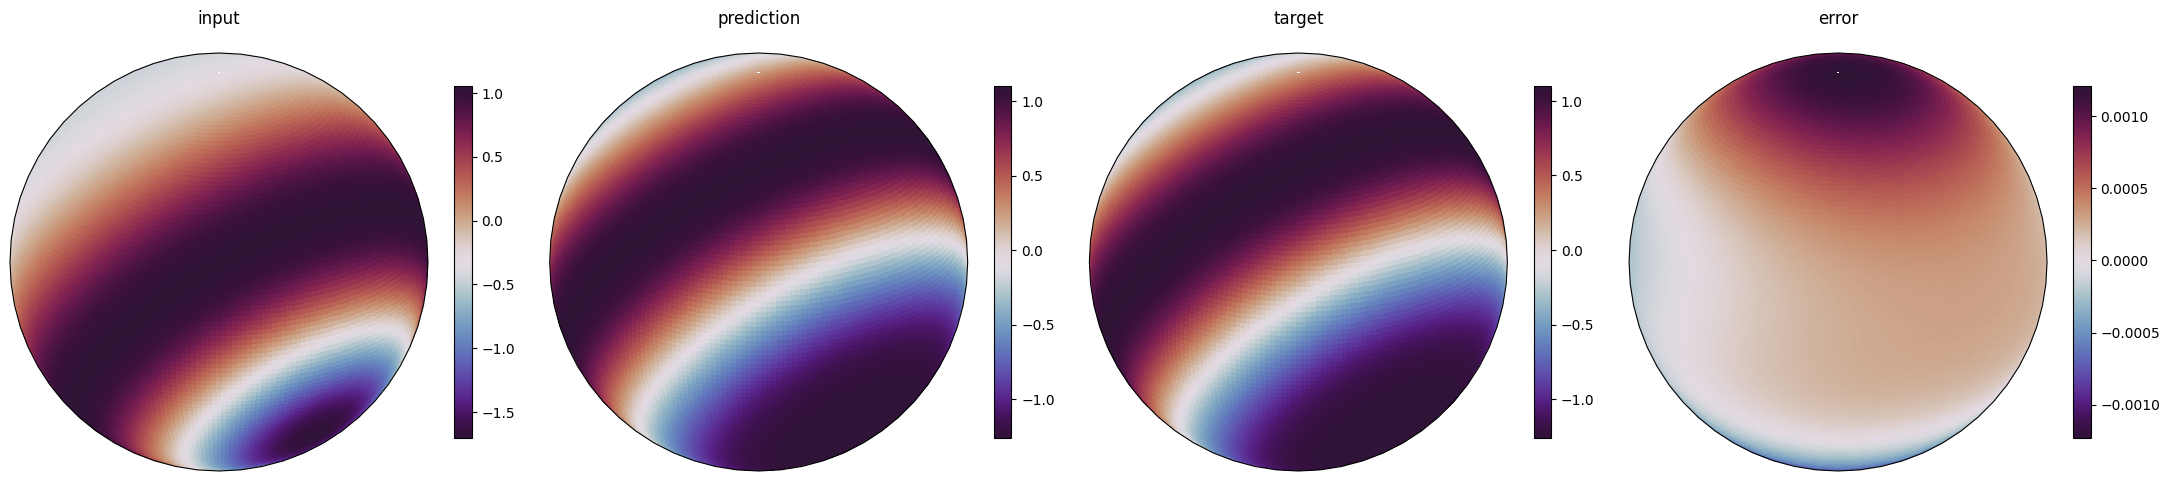

In [79]:
torch.manual_seed(0)

dataloader.dataset.set_nfuture(0)

with torch.inference_mode():
    inp, tar = next(iter(dataloader))
    out = model(inp).detach()

s = 0; ch = 0  # sample and channel index

# ---------------------------------------------------------
# Combined 1×4 plot: input, prediction, target, error
# ---------------------------------------------------------
fig = plt.figure(figsize=(22, 5))

proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)

axes = [
    fig.add_subplot(1, 4, 1, projection=proj),
    fig.add_subplot(1, 4, 2, projection=proj),
    fig.add_subplot(1, 4, 3, projection=proj),
    fig.add_subplot(1, 4, 4, projection=proj),
]

titles = ["input", "prediction", "target", "error"]
data_list = [
    inp[s, ch],
    out[s, ch],
    tar[s, ch],
    (tar - out)[s, ch],
]

for ax, data, title in zip(axes, data_list, titles):
    im = dataset.plot_griddata(
        data,
        fig=fig,
        projection='3d',
        title=title,
        ax=ax
    )
    fig.colorbar(im, ax=ax, shrink=0.75)

plt.tight_layout()
plt.show()


# Visualize evolution over greater timerange

In [74]:
dataloader.dataset.set_nfuture(0)

t_vec = np.arange(t0, 3, dt) #t0, tf, dt
f_handle = gen_random_gaussian_handle()
g_handle = lambda x, y, z: 0 * x
s = 0; ch = 0 # Sample and c

inp = dataset.time2grid(f_handle, g_handle, t_vec[:history]).unsqueeze(0)

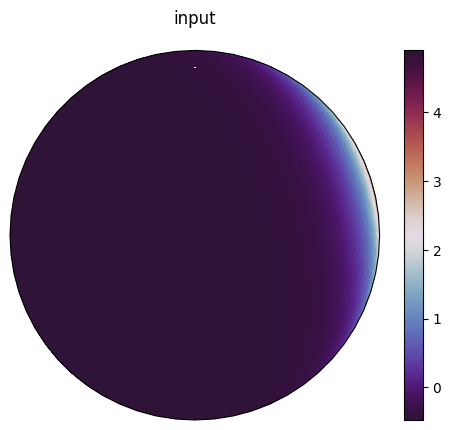

In [75]:
s = 0; ch = 0 # Sample and c

fig = plt.figure()
im = dataset.plot_griddata(inp[s, ch], fig, projection='3d', title='input')
plt.colorbar(im)
plt.show()

[info] Computing frame 0/29  (t = 0.4000)


[info] Computing frame 10/29  (t = 1.4000)
[info] Computing frame 20/29  (t = 2.4000)


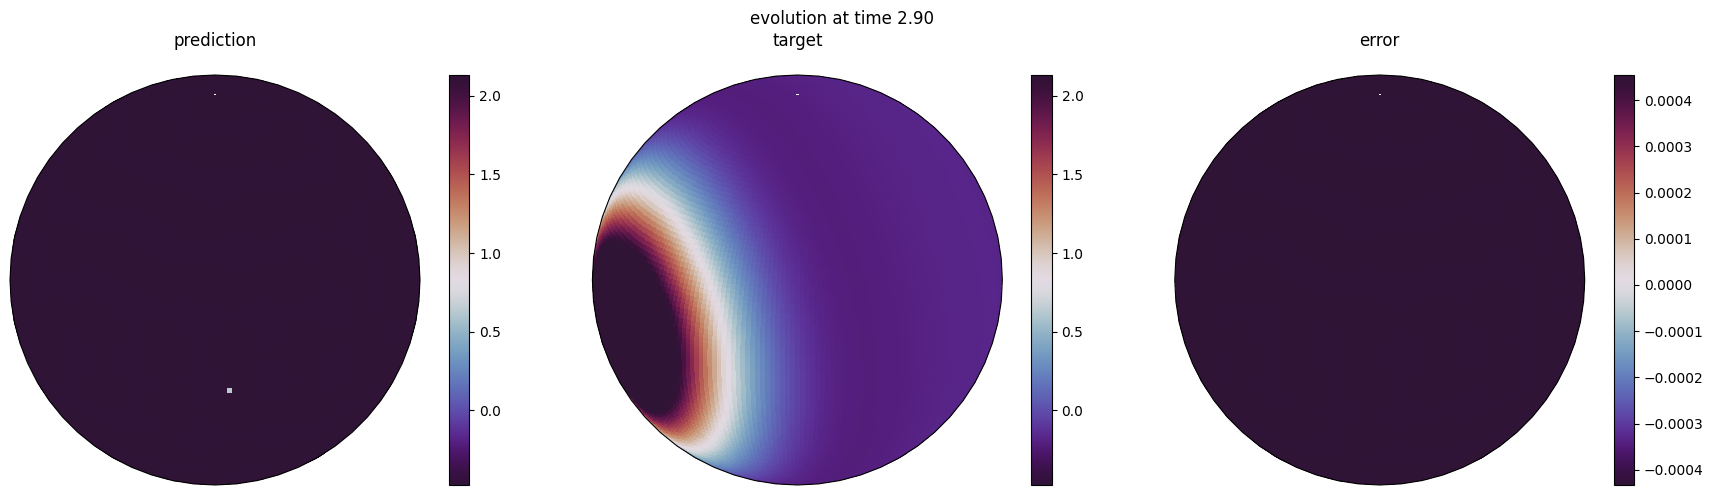

In [76]:

video_name = f"wave_evolution_v2_history{history}_samples{num_examples}_dt{dt}_tf{tf}_epochs{nepochs}_nfut{nfuture}.mp4"

# 1) Precompute predicted frames using your iterative model
frames = []

inp_cur = inp.clone() 


for i, t_val in enumerate(t_vec[history:]):  
    
    if i % 10 == 0:   # print every 10 frames
        print(f"[info] Computing frame {i}/{len(t_vec)-1}  (t = {t_val:.4f})")
    
    inp_cur = torch.as_tensor(inp_cur, dtype=torch.float32)
    out = model(inp_cur).detach()
    tar = dataset.time2grid(f_handle, g_handle, t_val).unsqueeze(0).unsqueeze(0)
    
    

    frames.append({
        "t": float(t_val),
        "out": out.clone(),
        "tar": tar.clone(),
    })

    # updates input acording to history: autoregressive update
    inp_cur = torch.cat((inp_cur[0,1:,...], out[0,...])).unsqueeze(0)


# 2) Set up figure with 3 subplots
fig = plt.figure(figsize=(18, 5))
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)

axes = [
    fig.add_subplot(1, 3, 1, projection=proj),
    fig.add_subplot(1, 3, 2, projection=proj),
    fig.add_subplot(1, 3, 3, projection=proj)
]

def to_1d_array(x):
    if torch.is_tensor(x):
        return x.detach().cpu().numpy().ravel()
    return np.asarray(x).ravel()


# 3) Draw FIRST *predicted* frame (frames[0])   <-- NO initial frame shown
f0 = frames[0]
out0 = f0["out"][s, ch]
tar0 = f0["tar"][s, ch]
err0 = (f0["tar"] - f0["out"])[s, ch]

im_pred = dataset.plot_griddata(out0, fig, projection='3d',
                                title="prediction", ax=axes[0])
fig.colorbar(im_pred, ax=axes[0])

im_tar = dataset.plot_griddata(tar0[0], fig, projection='3d',
                               title="target", ax=axes[1])
fig.colorbar(im_tar, ax=axes[1])

im_err = dataset.plot_griddata(err0[0], fig, projection='3d',
                               title="error", ax=axes[2])
fig.colorbar(im_err, ax=axes[2])

fig.suptitle(f"evolution at time {f0['t']}")
fig.subplots_adjust(top=0.85) 
plt.tight_layout()

# 4) Animation update function
def update(i):
    
    
    f = frames[i]     # start at frames[0], frames[1], ...
    t_val = f["t"]

    out = f["out"][s, ch]
    tar = f["tar"][s, ch]
    err = (f["tar"] - f["out"])[s, ch]

    im_pred.set_array(to_1d_array(out))
    im_tar.set_array(to_1d_array(tar))
    im_err.set_array(to_1d_array(err))

    #plt.tight_layout()
    fig.suptitle(f"evolution at time {t_val:.2f}")
    fig.subplots_adjust(top=0.85) 


    return im_pred, im_tar, im_err


# 5) Create animation
anim = FuncAnimation(
    fig,
    update,
    frames=len(frames),   # starts at predicted frame 1
    interval=100,
    blit=False
)

anim.save(video_name, writer="ffmpeg", fps=5)
plt.show()
